Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.regularizers import l2

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive/')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/My Drive/app/CNN_assignment/Train")
data_dir_test = pathlib.Path('/content/drive/My Drive/app/CNN_assignment/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory( directory=data_dir_train,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory( directory=data_dir_train,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)
print(num_classes)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

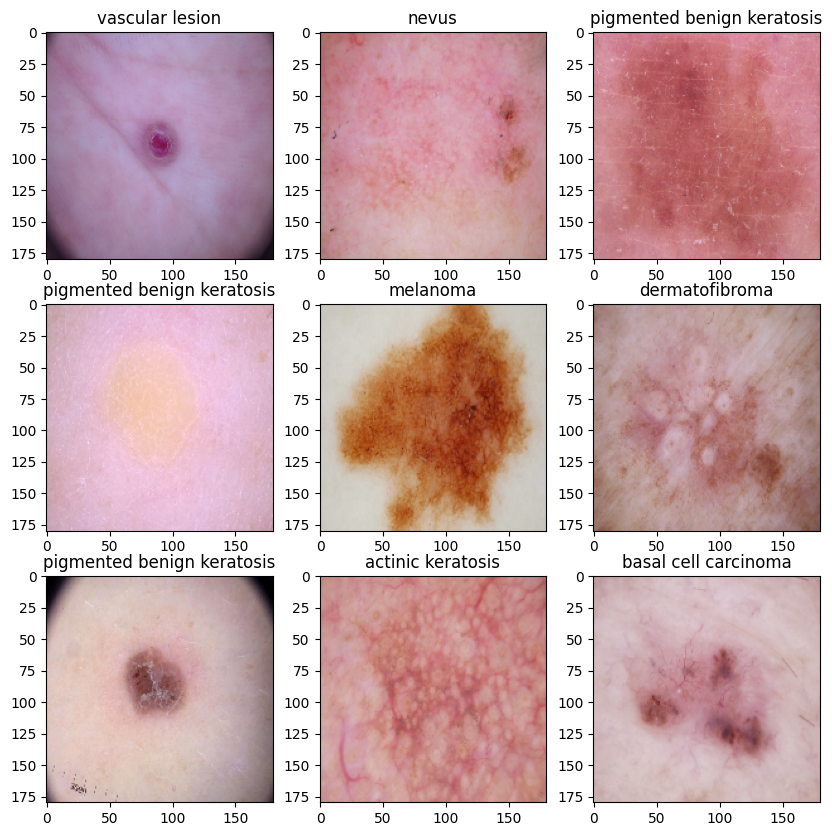

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(num_classes):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
model = Sequential()
model.add(tf.keras.layers.Rescaling(scale=1./255,input_shape=(img_height, img_width, 3)))
model.add(Conv2D(180, (3, 3), padding='same',
                 input_shape=(img_height, img_width,1)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(len(class_names)))
model.add(Activation('softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer="sgd",loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 180)     5040      
                                                                 
 activation (Activation)     (None, 180, 180, 180)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      51872     
                                                                 
 activation_1 (Activation)   (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                        

### Train the model

In [14]:
epochs =20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 73s 904ms/step - loss: 2.0390 - accuracy: 0.2059 - val_loss: 2.0414 - val_accuracy: 0.3468
Epoch 2/20
56/56 [==============================] - 9s 161ms/step - loss: 2.0175 - accuracy: 0.2506 - val_loss: 2.0229 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 9s 165ms/step - loss: 1.9888 - accuracy: 0.2517 - val_loss: 2.0182 - val_accuracy: 0.2081
Epoch 4/20
56/56 [==============================] - 9s 162ms/step - loss: 1.9752 - accuracy: 0.2684 - val_loss: 1.9643 - val_accuracy: 0.2662
Epoch 5/20
56/56 [==============================] - 9s 158ms/step - loss: 1.9330 - accuracy: 0.2952 - val_loss: 1.8253 - val_accuracy: 0.3669
Epoch 6/20
56/56 [==============================] - 9s 155ms/step - loss: 1.8922 - accuracy: 0.3147 - val_loss: 1.9017 - val_accuracy: 0.2886
Epoch 7/20
56/56 [==============================] - 9s 153ms/step - loss: 1.8369 - accuracy: 0.3265 - val_loss: 2.3591 - val_accuracy: 0.2304
Epoch 8/20
56/56

### Visualizing training results

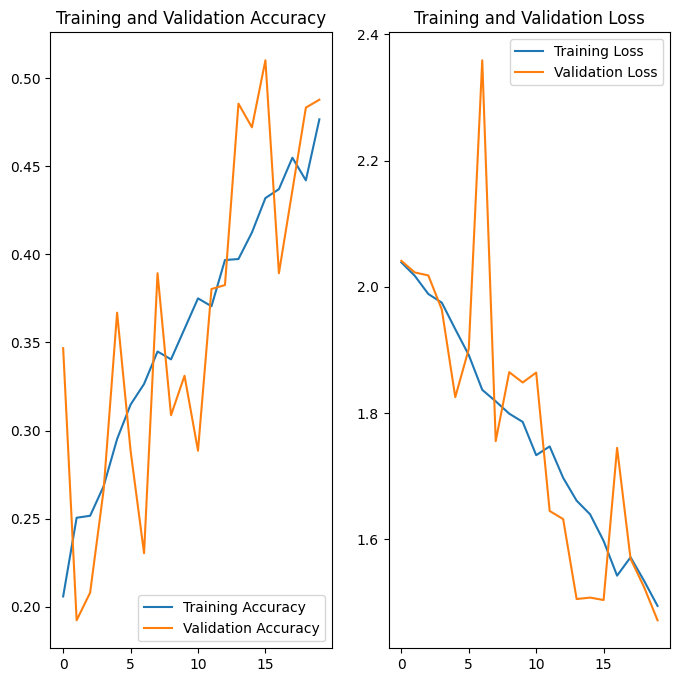

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit


1.   **Train Accuracy gradually increasing**
2.   **Validation Accuracy not stable**
3.   **Train loss gradually decreasing**
4.   **Validation loss not stable**


### **Model tend overfit on training data,but performance unstably on the validtion data**


### Write your findings here

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

### Todo:
### Create the model, compile and train the model

#### Will introduce the dropout,batch normalisation and change the optimizer with learning rate


In [33]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

## Will introduce the dropout and batch normalisation
model1 = Sequential()
model1.add(tf.keras.layers.Rescaling(scale=1./255,input_shape=(img_height, img_width, 3)))

#model.add(Conv2D(180, (3, 3), padding='same',input_shape=(img_height, img_width,1)))

model1.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(img_height, img_width,1)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(32, (3, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(64, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(128, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(128, (3, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(512,kernel_regularizer=l2(0.01)))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(num_classes))
model1.add(Activation('softmax'))


### Compiling the model

In [34]:
## Your code goes here
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

In [35]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_35 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_22 (Ba  (None, 180, 180, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_26 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 activation_36 (Activation)  (None, 178, 178, 32)      0         
                                                      

### Training the model

In [36]:
## Your code goes here, note: train your model for 20 epochs
epochs =20
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 13s 179ms/step - loss: 13.3918 - accuracy: 0.2533 - val_loss: 12.5985 - val_accuracy: 0.0425
Epoch 2/20
56/56 [==============================] - 10s 171ms/step - loss: 12.2570 - accuracy: 0.3504 - val_loss: 13.0160 - val_accuracy: 0.1566
Epoch 3/20
56/56 [==============================] - 10s 174ms/step - loss: 11.8949 - accuracy: 0.3795 - val_loss: 13.3527 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 10s 176ms/step - loss: 11.7664 - accuracy: 0.4040 - val_loss: 13.6022 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 10s 172ms/step - loss: 11.6852 - accuracy: 0.4196 - val_loss: 13.7278 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 10s 170ms/step - loss: 11.5614 - accuracy: 0.4531 - val_loss: 13.6538 - val_accuracy: 0.1499
Epoch 7/20
56/56 [==============================] - 10s 170ms/step - loss: 11.5256 - accuracy: 0.4503 - val_loss: 13.5839 - val_ac

### Visualizing the results

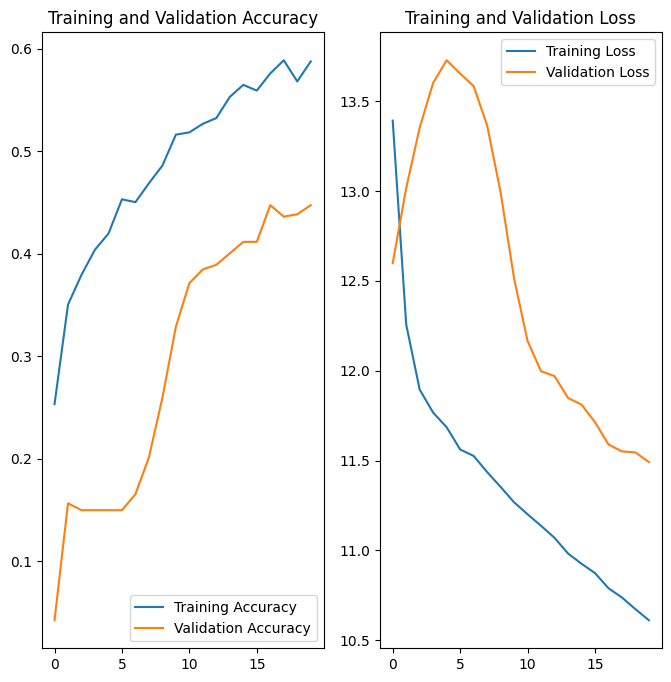

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?



*   Train Accuracy and Validation Accuracy stably increasing
*   both the accuracy still is low



**Improvement from previous model**


*   Both Train and validation loss gradually decreasing so the learning happen correct manner






#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [38]:
## Your code goes here.
train_pd = pd.DataFrame(columns=["Class_Name","Total","Percentage"])
for dir_name in os.listdir(data_dir_train):
   total_image_in_folder = len(list(data_dir_train.glob(dir_name+"/*.jpg")))
   df = {"Class_Name":dir_name,"Total":total_image_in_folder,"Percentage":round((total_image_in_folder/image_count_train)*100,2)}
   #train_pd = train_pd.append(df)
   train_pd = pd.concat([train_pd, pd.DataFrame([df])], ignore_index=True)

train_pd = train_pd.set_index("Class_Name")
display(train_pd.sort_values(by="Percentage",ascending=False))

,Total,Percentage
Class_Name,,
pigmented benign keratosis,462,20.63
melanoma,438,19.56
basal cell carcinoma,376,16.79
nevus,357,15.94
squamous cell carcinoma,181,8.08
vascular lesion,139,6.21
actinic keratosis,114,5.09
dermatofibroma,95,4.24
seborrheic keratosis,77,3.44


from matplotlib import pyplot as plt
_df_0['Percentage'].plot(kind='hist', bins=20, title='Percentage')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Percentage'].plot(kind='line', figsize=(8, 4), title='Percentage')
plt.gca().spines[['top', 'right']].set_visible(False)

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
**seborrheic keratosis has very less samples 77**
#### - Which classes dominate the data in terms proportionate number of samples?
**pigmented benign keratosis has highest number of samples which 20.63% on total train data**

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [39]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [40]:
path_to_training_dataset="/content/drive/My Drive/app/CNN_assignment/Train/"
import Augmentor
for i in class_names:
    print(i)
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/app/CNN_assignment/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x77FFA027A800>: 100%|██████████| 500/500 [00:21<00:00, 23.37 Samples/s]


basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/app/CNN_assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x77FFA0245FC0>: 100%|██████████| 500/500 [00:24<00:00, 20.43 Samples/s]


dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/app/CNN_assignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78000041F490>: 100%|██████████| 500/500 [00:17<00:00, 28.48 Samples/s]


melanoma
Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/app/CNN_assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x77FF7C4BFD30>: 100%|██████████| 500/500 [01:28<00:00,  5.62 Samples/s]


nevus
Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/app/CNN_assignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x77FF7C7AC400>: 100%|██████████| 500/500 [01:18<00:00,  6.34 Samples/s]


pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/app/CNN_assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x77FF7F375F30>: 100%|██████████| 500/500 [00:20<00:00, 24.87 Samples/s]


seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/app/CNN_assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x77FF7C7AC130>: 100%|██████████| 500/500 [00:42<00:00, 11.78 Samples/s]


squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/app/CNN_assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x77FF7C7CD720>: 100%|██████████| 500/500 [00:19<00:00, 25.50 Samples/s]


vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/app/CNN_assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x77FFA02C46A0>: 100%|██████████| 500/500 [00:18<00:00, 26.58 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [41]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [42]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/My Drive/app/CNN_assignment/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027795.jpg_828a6e28-1308-47a5-9fec-3d4779797a8a.jpg',
 '/content/drive/My Drive/app/CNN_assignment/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025577.jpg_527c6830-d078-4718-a158-6aa917e8f235.jpg',
 '/content/drive/My Drive/app/CNN_assignment/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030487.jpg_464694a4-2d14-4d3f-af06-ad0d0de90973.jpg',
 '/content/drive/My Drive/app/CNN_assignment/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029002.jpg_34e9d33d-95bb-441a-be70-71ddb9201b2f.jpg',
 '/content/drive/My Drive/app/CNN_assignment/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030714.jpg_6b25bf3e-ea41-449f-a95b-3b1eedc4f462.jpg',
 '/content/drive/My Drive/app/CNN_assignment/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_00294

In [43]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [44]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [45]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
display(df2.sort_values(by="Label",ascending=False))

#new_df = original_df.append(df2)

#train_pd = pd.concat([train_pd, pd.DataFrame([df])], ignore_index=True)

,Path,Label
1497,/content/drive/My Drive/app/CNN_assignment/Tra...,vascular lesion
1169,/content/drive/My Drive/app/CNN_assignment/Tra...,vascular lesion
1156,/content/drive/My Drive/app/CNN_assignment/Tra...,vascular lesion
1157,/content/drive/My Drive/app/CNN_assignment/Tra...,vascular lesion
1158,/content/drive/My Drive/app/CNN_assignment/Tra...,vascular lesion
...,...,...
1838,/content/drive/My Drive/app/CNN_assignment/Tra...,actinic keratosis
1839,/content/drive/My Drive/app/CNN_assignment/Tra...,actinic keratosis
1840,/content/drive/My Drive/app/CNN_assignment/Tra...,actinic keratosis
1841,/content/drive/My Drive/app/CNN_assignment/Tra...,actinic keratosis


In [46]:
print(df2['Path'].iloc[0])

/content/drive/My Drive/app/CNN_assignment/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027795.jpg_828a6e28-1308-47a5-9fec-3d4779797a8a.jpg


In [47]:
df2['Label'].value_counts()

Label
squamous cell carcinoma       500
melanoma                      500
vascular lesion               500
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
seborrheic keratosis          500
nevus                         500
pigmented benign keratosis    500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [48]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [50]:
data_dir_train="/content/drive/My Drive/app/CNN_assignment/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [51]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [58]:
## your code goes here
model2 = Sequential()
model2.add(tf.keras.layers.Rescaling(scale=1./255,input_shape=(img_height, img_width, 3)))

#model2.add(Conv2D(180, (3, 3), padding='same',input_shape=(img_height, img_width,1)))

model2.add(Conv2D(32, (3, 3), padding='same',input_shape=(img_height, img_width,1)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
#model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(128, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(256,kernel_regularizer=l2(0.01)))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [59]:
## your code goes here
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

In [60]:
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_49 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_32 (Ba  (None, 180, 180, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 90, 90, 64)       

#### **Todo:**  Train your model

In [61]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 48s 249ms/step - loss: 7.3696 - accuracy: 0.2923 - val_loss: 8.2935 - val_accuracy: 0.1411
Epoch 2/30
169/169 [==============================] - 44s 250ms/step - loss: 6.6916 - accuracy: 0.4047 - val_loss: 8.2676 - val_accuracy: 0.2502
Epoch 3/30
169/169 [==============================] - 42s 242ms/step - loss: 6.5237 - accuracy: 0.4490 - val_loss: 7.1159 - val_accuracy: 0.3801
Epoch 4/30
169/169 [==============================] - 43s 243ms/step - loss: 6.3375 - accuracy: 0.4985 - val_loss: 6.3151 - val_accuracy: 0.5427
Epoch 5/30
169/169 [==============================] - 44s 253ms/step - loss: 6.2236 - accuracy: 0.5321 - val_loss: 6.0350 - val_accuracy: 0.6132
Epoch 6/30
169/169 [==============================] - 43s 248ms/step - loss: 6.0938 - accuracy: 0.5558 - val_loss: 5.8736 - val_accuracy: 0.6444
Epoch 7/30
169/169 [==============================] - 43s 249ms/step - loss: 5.9668 - accuracy: 0.5886 - val_loss: 5.7986 - val_ac

#### **Todo:**  Visualize the model results

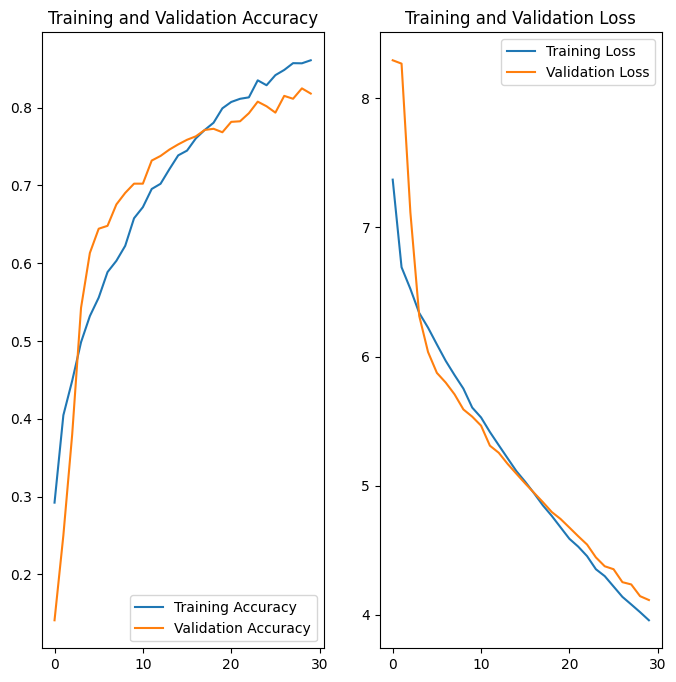

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?




**Now we overcome overfitting problem on the new model with the help of class rebalance.**



1.   **Train Accuracy 86.09% and Validation Accuracy 81.81% after last epoch(30)**
2.  **Train Loss and Validation Loss decreasing gradually**


In [64]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed = 123,
    image_size = (img_height,img_width),
    batch_size = batch_size
)
loss , accuracy = model2.evaluate(test_ds)

Found 118 files belonging to 9 classes.
4/4 [==============================] - 5s 145ms/step - loss: 6.6912 - accuracy: 0.4492
